## Freezing Card Shape Analysis
### Team 2
Jonah Krop  
Shruti Pareshbhai Gandhi  
Vedant Hareshbhai Patel  



In this part of the homework, we used PCA and KMeans clustering to identify cards with shapes resembling the `freezing` pattern displayed in the assignment. We also designed a simple regression model to identify some good examples of what a `freezing` card is, and used those classifications as a heuristic to evaluate what combination of clustering and dimensional reductions were effectively identifying the `freezing` pattern.

As a result, we've identified **44** total cards that resemble the `freezing` pattern.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import Counter

pd.set_option('display.max_rows', 200)

### First Step: Testing Raw Data
First thing we did was plot min and max values of `position` and `load` from the raw data in order to identify potential outliers and incorrect values. The results from this inform the logic in the `test_row()` function in the next part.

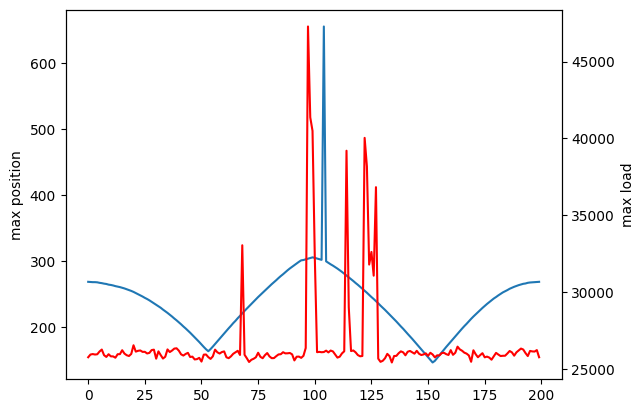

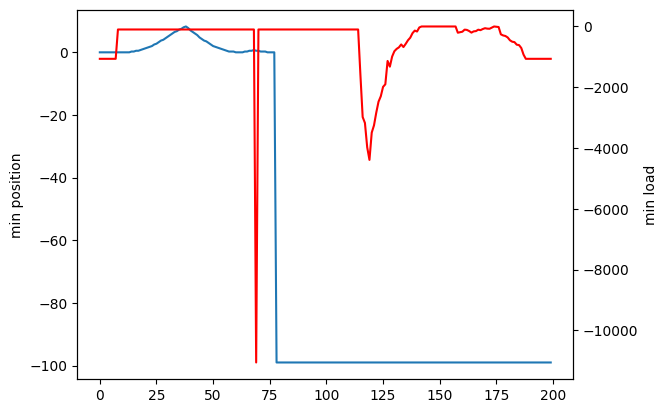

In [23]:
# start with graphing some raw data to get an idea of things
raw = pd.read_csv('Downloads/DSCI_552_CardShape_2014_01_01.csv')

x = list(range(200))
p_max, l_max, p_min, l_min = [], [], [], []
for i in x:
    p_max.append(max(raw.iloc[:, i+5]))
    l_max.append(max(raw.iloc[:, i+205]))
    p_min.append(min(raw.iloc[:, i+5]))
    l_min.append(min(raw.iloc[:, i+205]))

fig1, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(x, p_max)
ax2.plot(x, l_max, color='r')
ax1.set_ylabel('max position')
ax2.set_ylabel('max load')

fig1, ax3 = plt.subplots()
ax4 = ax3.twinx()
ax3.plot(x, p_min)
ax4.plot(x, l_min, color='r')
ax3.set_ylabel('min position')
ax4.set_ylabel('min load')

plt.show()

### Clean and Process Data
In this step, we define several functions used in our analysis:
- `test_row`, which removes rows from the dataset that contain invalid or undesired data
- `normalize`, which performs min/max scaling to map each set of positions and loads to a [0, 1] space
- `tare_start`, which rotates each row of data to set `Position0` (and the corresponding `Load0`) to the largest position value
- `decompose`, which performs dimensional reduction on the position and load data with PCA
- `load_and_clean`, which calls above functions to load the dataset and clean it for use

To start, we process the data and obtain two cleaned datasets, one with normalized values and one with original values.

In [3]:
def test_row(row):
    '''
    Receives a row of data from dataset and determines whether it should be kept.
    
    '''
    
    # initialize
    scaler = MinMaxScaler()
    keep = True
    
    # save position and load data
    pos = row[5:205]
    load = row[205:405]
    
    # test for bad data
    if row['NumPoints'] != 200:
        keep = False
    elif max(pos) > 350 or min(pos) < 0:
        keep = False
    elif max(load) > 30000 or min(load) < 0:
        keep = False
    
    return keep


def normalize(row, val):
    '''
    Given a row of data, return normalized values.
    '''
    
    # initialize
    scaler = MinMaxScaler()
    
    # load columns and reformat
    if val == 'position':
        data = np.array(row[5:205]).reshape(-1, 1)
    elif val == 'load':
        data = np.array(row[205:405]).reshape(-1, 1)
    else:
        raise SyntaxError('Unknown value in normalize')
        
    # return scaled data in acceptable format
    scaled = scaler.fit_transform(data).reshape(1, -1)[0]

    return scaled


def tare_start(row):
    '''
    Re-orders columns of position and load data such that all cards start at max position.
    
    '''
    
    # find index of maximum position value
    start = list(row[5:205]).index(max(row[5:205]))
    
    # rotate position and load data to start at that index
    new_pos = list(row[5+start:205]) + list(row[5:5+start])
    new_load = list(row[205+start:]) + list(row[205:205+start])
    
    # reset columns to new values
    row[5:205] = new_pos
    row[205:] = new_load
    
    return row


def decompose(data, n, style):
    '''
    Receives a dataset and reduces position and load data into n columns each.
    
    '''
    
    # get base data
    df_decomp = data.iloc[:, 0:5]
    
    # initialize pca
    pca = PCA(n_components=n)
    
    if style == 'separate':
        p_decomp = pca.fit_transform(data.iloc[:, 5:205])
        l_decomp = pca.fit_transform(data.iloc[:, 205:405])

        # create column names according to the # of reduced columns
        p_cols, l_cols = [], []
        for nn in range(n):
            p_cols.append('p_decomp{nn}'.format(nn=nn))
            l_cols.append('l_decomp{nn}'.format(nn=nn))

        # save results
        df_decomp[p_cols] = p_decomp
        df_decomp[l_cols] = l_decomp
        
    elif style == 'together':
        decomp = pca.fit_transform(data.iloc[:, 5:405])
        
        # create column names according to the # of reduced columns
        cols = []
        for nn in range(n):
            cols.append('decomp{nn}'.format(nn=nn))

        # save results
        df_decomp[cols] = decomp
    else:
        raise SyntaxError('unknown style')
        
    return df_decomp

    
def load_and_clean(path):
    '''
    Taking a path to data, load file and clean by removing undesired rows. Also,
    performs data normalization and returns a normalized AND unnormalized dataset.
    
    '''
    
    raw = pd.read_csv(path)
    
    # remove messy rows
    raw['is_clean'] = raw.apply(lambda r: test_row(r), axis=1)
    clean = raw[raw.is_clean].reset_index(drop=True)
    del clean['is_clean']
        
    # start each card curve starting at max position    
    clean = clean.apply(lambda r: tare_start(r), axis=1)
        
    # compute normalized position and load data
    clean_norm = clean.copy(deep=True)
    for i in range(len(clean_norm)):
        clean_norm.iloc[i, 5:205] = normalize(clean_norm.iloc[i], 'position').round(3)
        clean_norm.iloc[i, 205:] = normalize(clean_norm.iloc[i], 'load').round(3)
        
    print('{x} rows removed from raw data'.format(x=len(raw) - len(clean)))
    
    return clean, clean_norm
    
path = 'Downloads/DSCI_552_CardShape_2014_01_01.csv'
df, df_norm = load_and_clean(path)

1746 rows removed from raw data


### Regression Model

As mentioned above, we fit an initial model to attempt to do some basic identification of `freezing` shape cards. Due to the size of the dataset, the somewhat loose definition of what a `freezing` pattern is, and the wide variety of card shapes in the dataset, it is difficult to evaluate how well we're doing at identifying cards that fit the pattern. Therefore, we designed a linear model that identifies some cards that are very likely to be good examples of the `freezing` criteria according to a stricter criteria. This will be a very helpful heuristic for evaluating the clustering we do later.

Our hypothesis is that a clustering algorithm will do a better job at identifying the general variety of `freezing` shapes than this linear model, but clusters that do a good job of identifying these specific ones will also identify the general variety.


We fit a regression between position and load for each card, excluding some noisy position values (which don't necessarily appear relevant to the `freezing` shape) and flag it if:
- the goodness of fit is high
- the relationship between position and load is positive and above a threshold
- the relationship between position and load is similar during up and down stroke

In fitting the linear model, position values near where the pump is changing directions are excluded. This helps avoid a significant amount of noise and focuses on the pattern of increasing load associated with sustained position increase.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/opt/homebrew/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


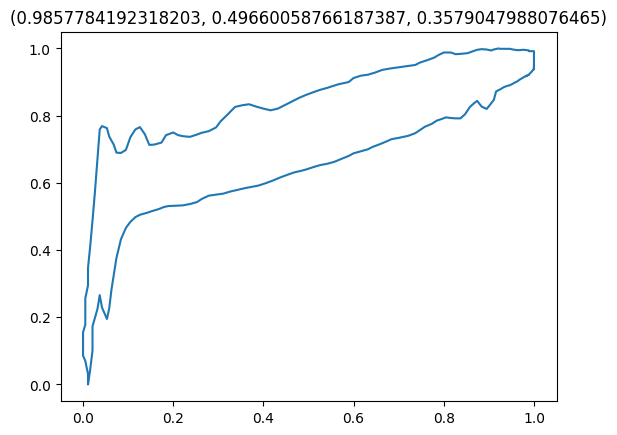

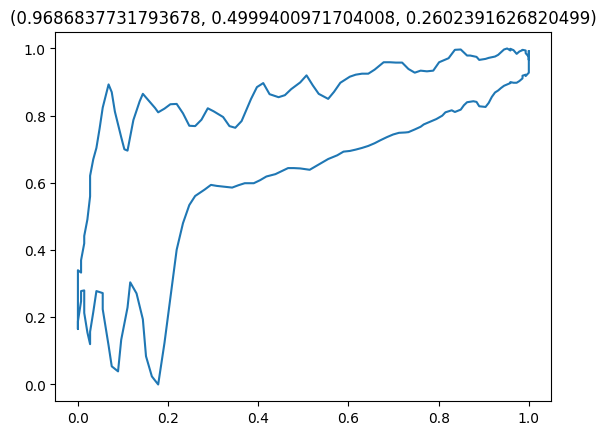

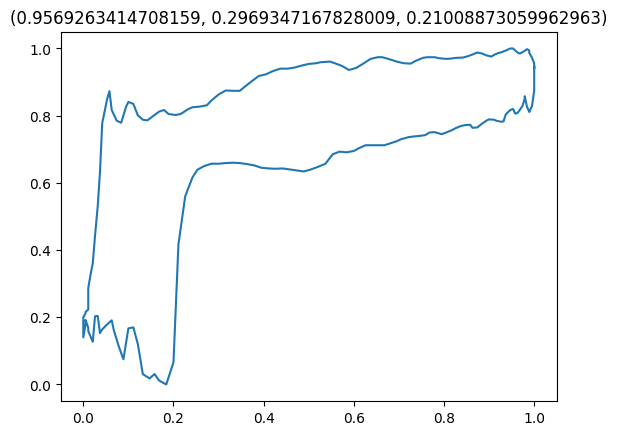

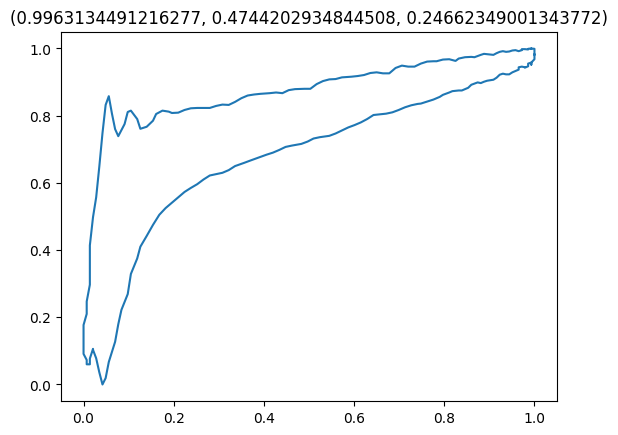

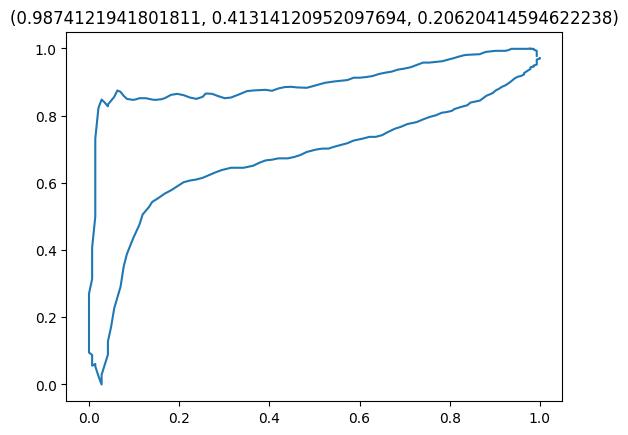

In [4]:
import statsmodels.formula.api as sm

results = {}
match = []
for i in range(len(df)):
    
    # exclude data points near where the pump is changing direction near
    # the start and middle of the dataset. excludes the first and last 10
    # points, and the middle 50.
    row = df_norm.iloc[i]
    pos = list(pd.concat([row.iloc[15:80], row.iloc[130:195]]))
    load = list(pd.concat([row.iloc[215:280], row.iloc[330:395]]))
    dr = [0 if r < 65 else 1 for r in list(range(130))] # flag for up or down stroke

    # initialize dataframe for modeling
    data = pd.DataFrame()
    data['position'] = pos
    data['load'] = load
    data['direction'] = dr
    m = sm.ols('load ~ position * direction', data=data).fit() # fit model with interaction for direction

    # save model results tied to the index of the data
    r2 = m.rsquared
    c1 = m.params['position']
    c2 = m.params['position'] + m.params['position:direction']
    c3 = abs(c2 - c1)
    
    # flag if r^2 is large and coefficients are positive and similar
    if r2 >= 0.9 and c1 >= 0.2 and c2 >= 0.2 and c3 <= 0.35:
        match.append(1)
        results[i] = (r2, c1, c2)
    else:
        match.append(0)

# plot some examples
for i in list(results.keys())[0:5]:
    plt.figure()
    plt.plot(list(df_norm.iloc[i, 5:205]), list(df_norm.iloc[i, 205:405]))
    plt.title(results[i])


### Clustering
Now that we have a basic heuristic for estimating whether a card resembles the `freezing` shape, we're considering several cases for evaluating a clustering model. Testing:
- different amounts of dimensional reduction (PCA)
- different styles of PCA (doing position and load data separately or together)
- different numbers of clusters

For each, we're recording the clustering results that obtain the best alignment with our heuristic. We use this big test to determine which setups do the best at identifying cards resembling the `freezing` shape. From there, the best-performing setups are used to see which cards are regularly identified, and claim those as the `freezing` card shapes!

In [5]:
# test different numbers of clusters and decomposition values
clusters = [40, 60, 80, 100]
decomp = [10, 20, 30, 40]
decomp_style = ['together', 'separate']

# initialize a dict to store testing results. store performance of cluster wrt heuristic,
# as well as the index of the wells associated with the best cluster
performance = {}
cards = {}
for dc in decomp:
    for st in decomp_style:        
        for c in clusters:
            s = str(dc) + '-' + str(st) + '-' + str(c)
            performance[s] = (0, 0) # score, cluster size
            cards[s] = []

# since kmeans can be random to initialization, run several times and avg the results
sims = 5
for sim in range(sims):
    print('starting sim {x}'.format(x=sim))
    
    # test different amounts of decomposition
    for dc in decomp:
        
        # test each style of PCA
        for st in decomp_style:
            
            # compute dataset
            data = decompose(df_norm, dc, st)

            # test different # of clusters
            for c in clusters:

                # compute clusters and load in tagged flags from regression above
                m = KMeans(n_clusters=c, n_init='auto').fit(data.iloc[:, 5:])
                data['cluster'] = m.labels_
                data['match'] = match # saved heuristic from above

                # group results by cluster
                g0 = data.groupby(by='cluster')['match'].mean().reset_index(name='acc')
                g1 = data.groupby(by='cluster').size().reset_index(name='num')
                g = pd.merge(g0, g1)

                # save the cluster that most accurately matches regression tagging
                # require a minimum cluster size
                best = g[g.num > 25].sort_values(by='acc', ascending=False)['acc'].reset_index(drop=True)[0]
                num = g[g.num > 25].sort_values(by='acc', ascending=False)['num'].reset_index(drop=True)[0]
                best_cluster = g[g.num > 25].sort_values(by='acc', ascending=False)['cluster'].reset_index(drop=True)[0]

                # save results of sim: performance of best, and wells in cluster
                s = str(dc) + '-' + str(st) + '-' + str(c)
                b = performance[s][0] + best
                n = performance[s][1] + num
                performance[s] = (b, n)
                cards[s] += list(data[data.cluster == best_cluster].index)

print('\n')
print('results:')

# gross line to pretty print results avg'd over all the simulations
print(json.dumps({k:str(round(v[0]/sims, 3)) + ', ' + str(round(v[1]/sims, 0)) for k, v in performance.items()}, indent=4))


starting sim 0
starting sim 1
starting sim 2
starting sim 3
starting sim 4


results:
{
    "10-together-40": "0.116, 117.0",
    "10-together-60": "0.125, 109.0",
    "10-together-80": "0.225, 61.0",
    "10-together-100": "0.192, 57.0",
    "10-separate-40": "0.126, 141.0",
    "10-separate-60": "0.213, 105.0",
    "10-separate-80": "0.327, 61.0",
    "10-separate-100": "0.284, 61.0",
    "20-together-40": "0.148, 128.0",
    "20-together-60": "0.644, 43.0",
    "20-together-80": "0.666, 41.0",
    "20-together-100": "0.636, 45.0",
    "20-separate-40": "0.12, 125.0",
    "20-separate-60": "0.141, 127.0",
    "20-separate-80": "0.313, 93.0",
    "20-separate-100": "0.519, 39.0",
    "30-together-40": "0.149, 113.0",
    "30-together-60": "0.504, 54.0",
    "30-together-80": "0.38, 59.0",
    "30-together-100": "0.62, 38.0",
    "30-separate-40": "0.117, 104.0",
    "30-separate-60": "0.165, 113.0",
    "30-separate-80": "0.321, 54.0",
    "30-separate-100": "0.491, 45.0",
    "40-tog

The top 5 or 6 models are all pretty similar, with the single best model containing ~60-70% of the cards flagged with the heuristic. Expectedly, the best-performing models reduce dimensionality across position and load -- the interaction of those values contributes to the `freezing` shape. Choosing the top 5:

In [19]:
# save the performance of each model
rnk = [v[0]/sims for v in performance.values()]
rnk.sort(reverse=True)

# save the references of the models that performed in the top 5
good = [k for (k, v) in performance.items() if v[0]/sims > rnk[5]]

# count the number of times each good setup identified each well,
# saving the wells that were identified more than once
saves = []
for g in good:
    d = dict(Counter(cards[g]))
    saves += [k for (k, v) in d.items() if v >= 2]
    
saves = list(set(saves))
saves.sort()

print('Identified {x} freezing card shapes at indices:'.format(x=len(saves)))
print(saves)

Identified 44 freezing card shapes at indices:
[211, 246, 425, 438, 574, 582, 717, 1082, 1085, 1097, 1107, 1112, 1251, 1370, 1576, 1930, 2004, 2323, 2664, 2782, 3200, 3758, 3767, 4237, 4536, 4603, 4640, 4693, 4759, 4845, 4847, 4864, 4889, 4897, 4934, 5032, 5074, 5246, 5426, 5524, 5934, 5989, 6018, 6269]


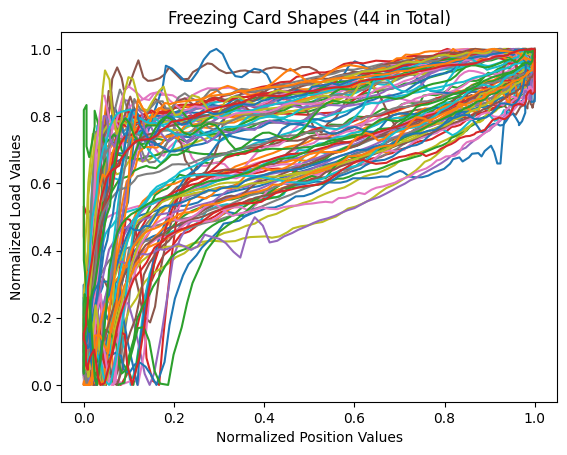

In [22]:
plt.figure()
for i in saves:
    plt.plot(df_norm.iloc[i, 5:205], df_norm.iloc[i, 205:405])
    
plt.title('Freezing Card Shapes ({x} in Total)'.format(x=len(saves)))
plt.xlabel('Normalized Position Values')
plt.ylabel('Normalized Load Values')
plt.show()